In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# figures inline, ignore warnings, setting visualisation style, standardisation
%matplotlib inline 
import warnings 
warnings.filterwarnings("ignore") 
sns.set()

# algo libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# evaluation libraries
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score

In [2]:
# load datasets
train_proc=pd.read_csv("train_proc.csv")
test_proc = pd.read_csv("test_proc.csv")

In [3]:
# splitting from training and validation data
X = train_proc.drop("Survived", axis =1)
y = train_proc['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [4]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,-0.551881,1,0,-0.726134,False,True,True,False,True,False,True,False,False
1,0.768879,1,0,2.353815,False,False,False,False,False,False,False,True,False
2,-0.221691,0,0,-0.693667,False,True,False,False,True,True,False,False,False
3,0.521236,1,0,1.479214,False,False,False,False,True,False,False,True,False
4,0.521236,0,0,-0.687655,False,True,True,False,True,False,True,False,False


In [5]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [6]:
# comparing decision tree models accuracy with depths 4,6 and 8
dt_model_4 = DecisionTreeClassifier(random_state=1, max_depth=4).fit(X_train,y_train)
dt_model_6 = DecisionTreeClassifier(random_state=1, max_depth=6).fit(X_train,y_train)
dt_model_8 = DecisionTreeClassifier(random_state=1, max_depth=8).fit(X_train,y_train)

In [7]:
print(f'Score with depth 4 : train {dt_model_4.score(X_train,y_train)}, test {dt_model_4.score(X_test,y_test)}')
print(f'Score with depth 6 : train {dt_model_6.score(X_train,y_train)}, test {dt_model_6.score(X_test,y_test)}')
# grid search CV for model optimisation
print(f'Score with depth 8 : train {dt_model_8.score(X_train,y_train)}, test {dt_model_8.score(X_test,y_test)}')

Score with depth 4 : train 0.8313253012048193, test 0.8203592814371258
Score with depth 6 : train 0.8644578313253012, test 0.7964071856287425
Score with depth 8 : train 0.8990963855421686, test 0.8323353293413174


In [8]:
# grid search CV for model optimisation
tree_model=DecisionTreeClassifier(random_state=11)
param_tree={'criterion':['gini', 'entropy'], 'max_depth':[2,4,6,8,10,None]}
grid_search = GridSearchCV(tree_model, param_tree, cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
print(grid_search.best_estimator_) # Get the best estimator from the grid search
print(grid_search.best_params_)
print(grid_search.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=11)
{'criterion': 'entropy', 'max_depth': 6}
0.8208247892458418


In [9]:
# random search CV for model optimisation
tree_model_ran=DecisionTreeClassifier(random_state=12)
random_search = RandomizedSearchCV(tree_model_ran, param_tree, cv=5, random_state=12)
random_search.fit(X_train,y_train)
print(random_search.best_estimator_) # Get the best estimator from the grid search
print(random_search.best_params_)
print(random_search.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=12)
{'max_depth': 6, 'criterion': 'entropy'}
0.8208247892458418


In [10]:
# cross validation score with random shuffling
kf=KFold(5, shuffle=True, random_state=10) #for shuffling
cross_val_results = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=6,random_state=15), 
                                    X_train, y_train, cv=kf)
print(cross_val_results)
print(cross_val_results.mean())

[0.78947368 0.77443609 0.78195489 0.83458647 0.78030303]
0.7921508316245158


In [11]:
# predictions on validation set and accuracy with optimised model
dt_model=DecisionTreeClassifier(random_state=1, max_depth=6).fit(X_train,y_train)
predictions = dt_model.predict(X_test)
print(accuracy_score(y_test,predictions))

0.7964071856287425


In [12]:
# confusion matrix
cm = confusion_matrix(y_test,predictions)
confusion_matrix(y_test,predictions)

array([[99, 13],
       [21, 34]], dtype=int64)

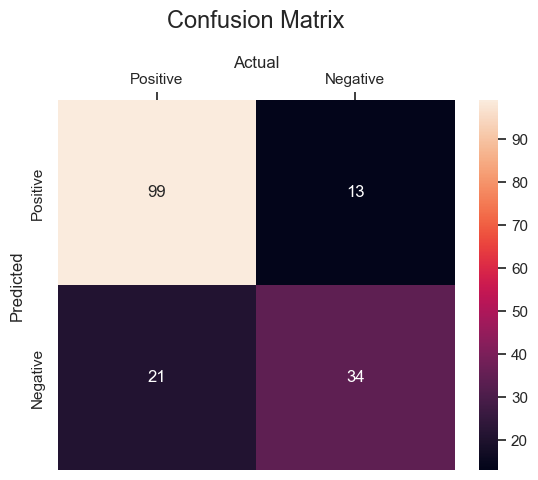

In [13]:
sns.heatmap(cm, 
            annot=True,
            fmt="d", 
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Predicted')
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.gca().xaxis.tick_top()
plt.xlabel('Actual')
plt.show()

In [14]:
# roc-auc curve
y_pred_prob = dt_model.predict_proba(X_test)[:,1]
fpr_dt,tpr_dt,threshold=roc_curve(y_test,y_pred_prob)
roc_auc_dt = auc(fpr_dt,tpr_dt)
print(roc_auc_dt)

0.808116883116883


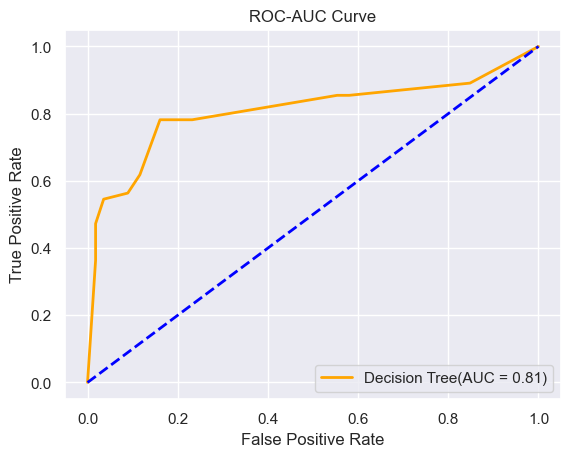

In [15]:
plt.figure()
plt.plot(fpr_dt,tpr_dt,color='orange',lw=2,label=f'Decision Tree(AUC = {roc_auc_dt:.2f})')
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],color='blue',lw=2,linestyle='--')

In [16]:
# classification report
report = classification_report(y_test,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       112
           1       0.72      0.62      0.67        55

    accuracy                           0.80       167
   macro avg       0.77      0.75      0.76       167
weighted avg       0.79      0.80      0.79       167



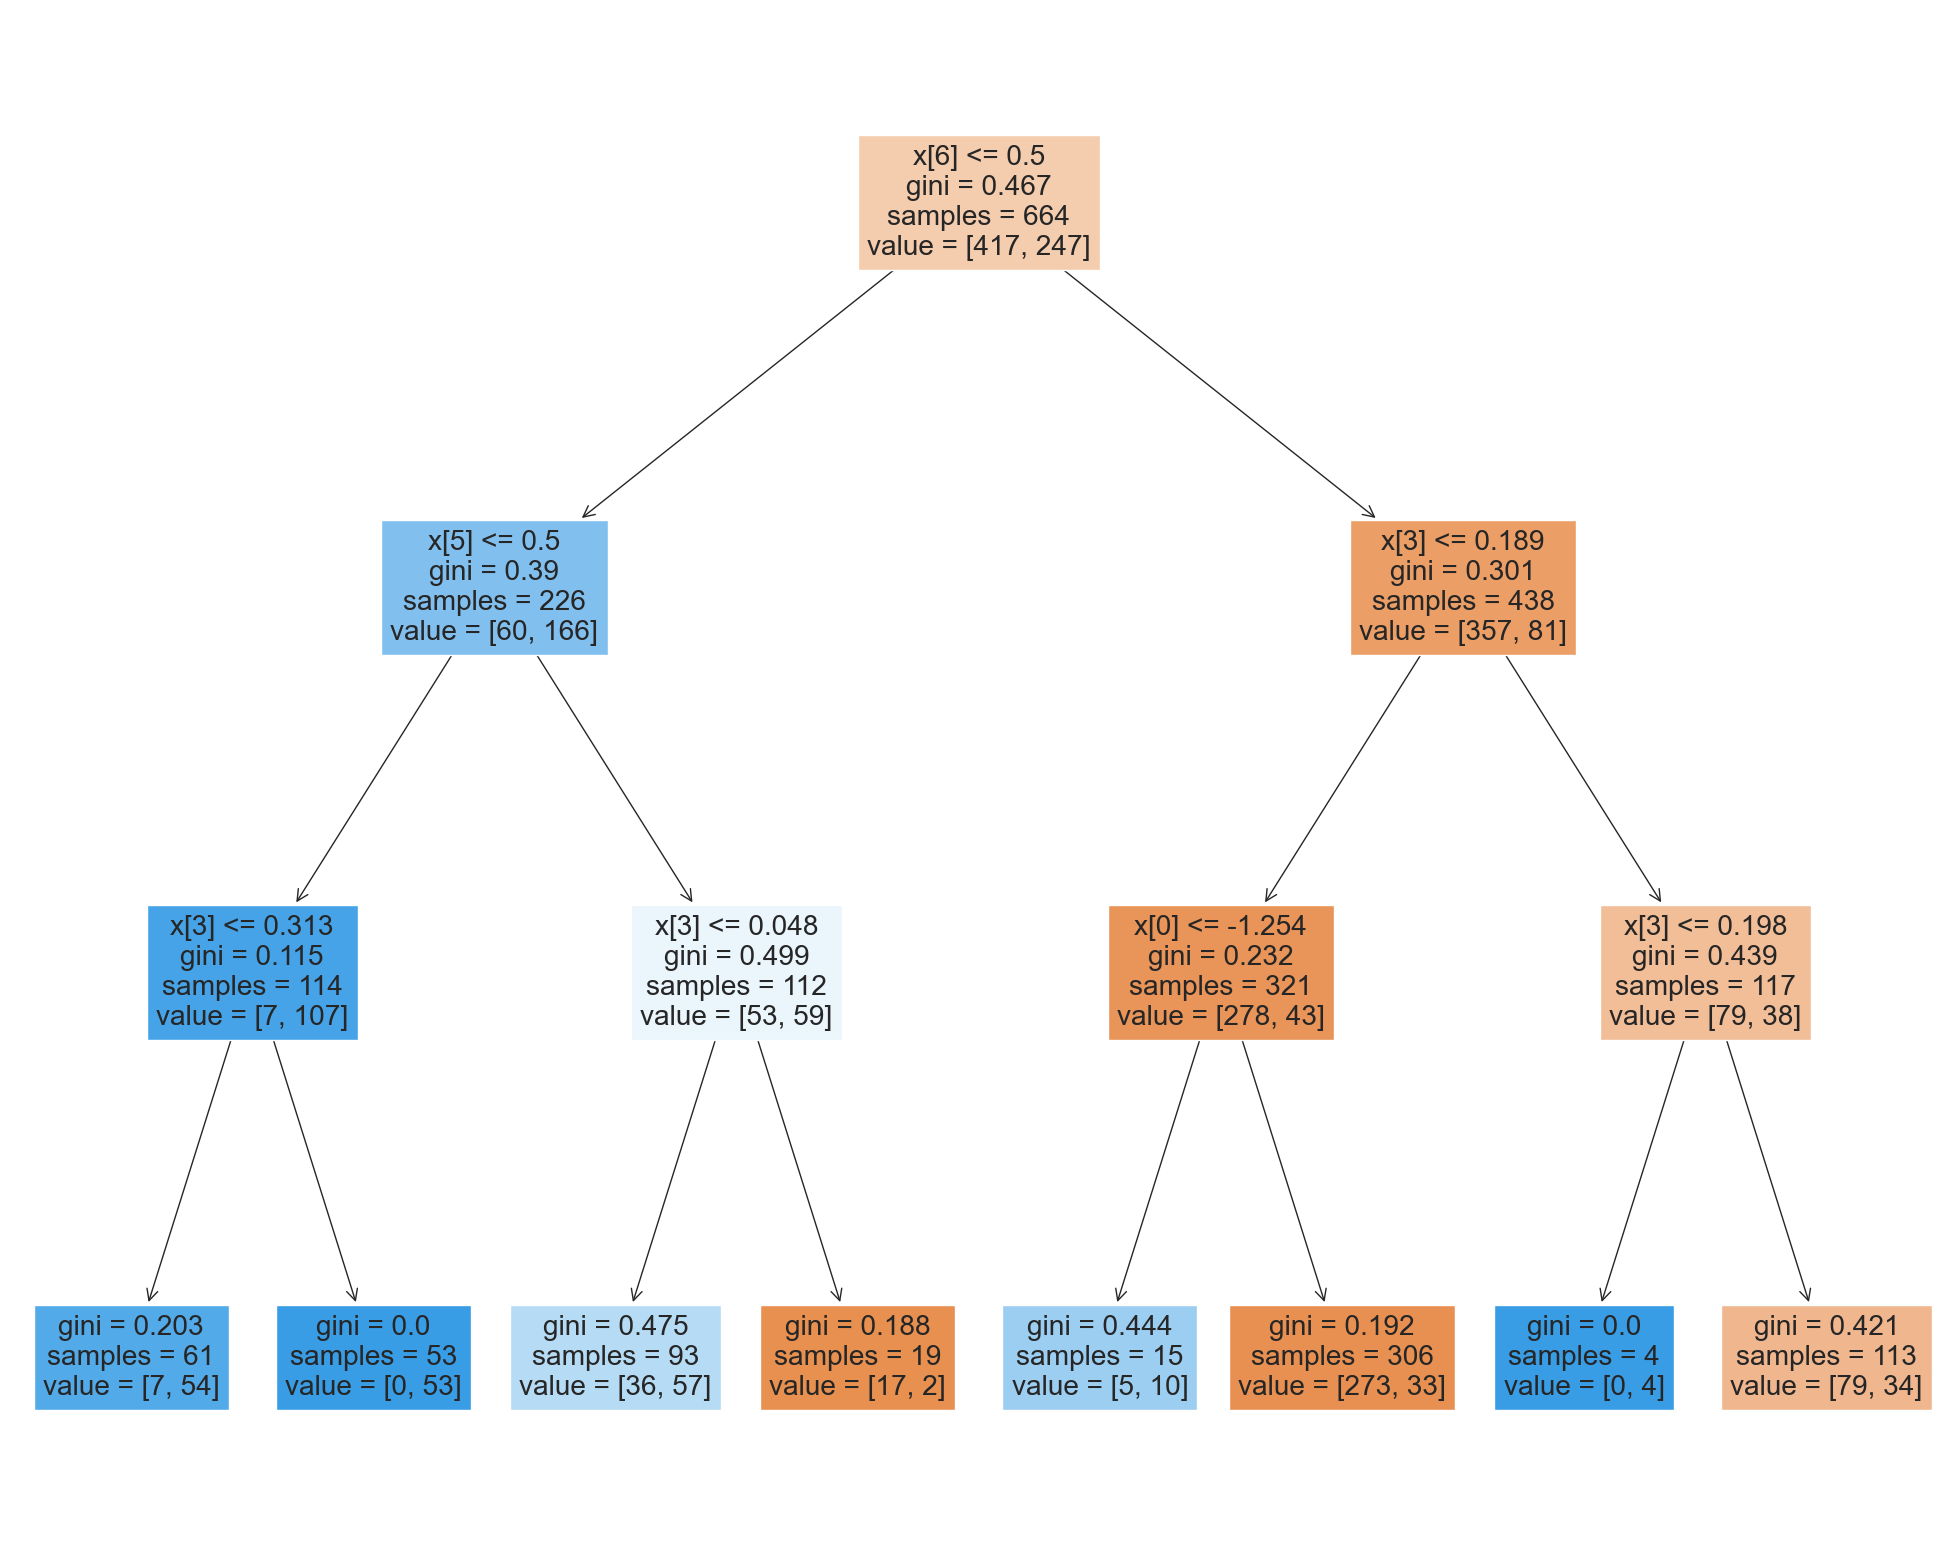

In [17]:
# tree visualisation
dt_model_tree=DecisionTreeClassifier(random_state=1, max_depth=3).fit(X_train,y_train)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt_model_tree,filled=True)
plt.show()

In [18]:
# predictions on test data
predictions = dt_model.predict(test_proc)

# creating dataframe of test predictions with Passenger Id, uncomment after loading test file with Passenger Id
# prediction_df = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predictions})

# Save the predictions to a CSV file, uncomment to save file
# prediction_df.to_csv('prediction.csv', index=False)